In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import preproc_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


2024-04-25 16:35:46.559059: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 16:35:46.586839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 16:35:47.049564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# importation des images

In [ ]:
df_images = pd.read_csv('df_images.csv')
df_masks = pd.read_csv('df_masks.csv')

In [ ]:
# importation et preprocessing des images
data, target = preproc_img(df_images, df_masks, n_img=900, normalize=True, files_path='PATH_NOMASK', resolution=[224, 224, 3], with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# test du modèle VGG16

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

def build_modified_vgg16(num_classes=4):
    # Charger le modèle VGG16 pré-entraîné sans la partie supérieure (top)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Geler toutes les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Ajouter de nouvelles couches
    x = base_model.output
    x = Flatten()(x)  
    x = Dense(256, activation='relu')(x)  
    predictions = Dense(num_classes, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#modèle prêt
modelVGG16 = build_modified_vgg16(num_classes=4)

2024-04-25 16:36:18.313633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 16:36:18.543720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 16:36:18.543769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 16:36:18.545534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 16:36:18.545565: I external/local_xla/xla/stream_executor

In [4]:
#Sauvegarde de l'history et entrainement du modèle
historyVGG16 = modelVGG16.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20


I0000 00:00:1714055781.177074    1566 service.cc:145] XLA service 0x7f99a400c4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714055781.177109    1566 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-25 16:36:21.237942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-25 16:36:21.433855: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2986 - loss: 1.6175

I0000 00:00:1714055785.489329    1566 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.6566 - loss: 0.8536 - val_accuracy: 0.8528 - val_loss: 0.4129
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8872 - loss: 0.3353 - val_accuracy: 0.9042 - val_loss: 0.3089
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9279 - loss: 0.2354 - val_accuracy: 0.9014 - val_loss: 0.2857
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9476 - loss: 0.1841 - val_accuracy: 0.9222 - val_loss: 0.2583
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9657 - loss: 0.1399 - val_accuracy: 0.9222 - val_loss: 0.2416
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9814 - loss: 0.1107 - val_accuracy: 0.9194 - val_loss: 0.2442
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9853 - loss: 0.0908 - val_accuracy: 0.9236 - val_loss: 0.2365
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9831 - loss: 0.0771 - val_accuracy: 0.9208 - val_loss: 

/tmp/ipykernel_1239/468632248.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(historyVGG16.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
/tmp/ipykernel_1239/468632248.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(historyVGG16.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')


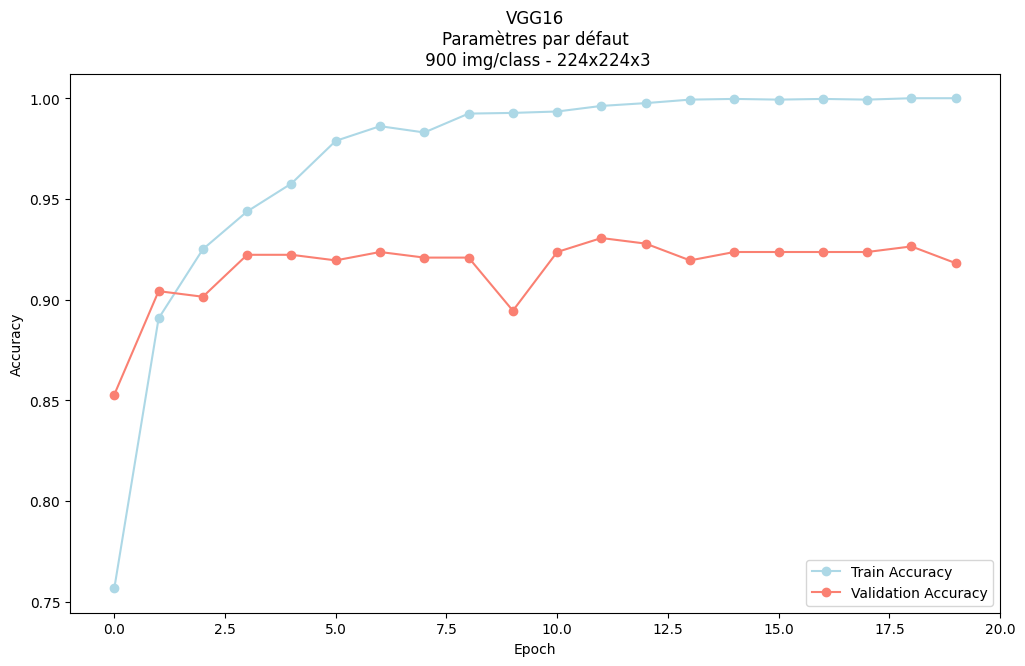

In [5]:
#Affichage de l'accuracy en fonction du temps 
plt.figure(figsize=(12, 7))
plt.plot(historyVGG16.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
plt.plot(historyVGG16.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')
plt.title('VGG16\nParamètres par défaut\n 900 img/class - 224x224x3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(-1,20)
plt.legend(loc='lower right')
plt.show()


In [6]:
# Prédiction sur l'ensemble de test
y_pred = modelVGG16.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
              precision    recall  f1-score   support

       COVID       0.97      0.92      0.95       192
        Lung       0.87      0.90      0.88       173
      Normal       0.85      0.88      0.86       176
       Viral       0.98      0.98      0.98       179

    accuracy                           0.92       720
   macro avg       0.92      0.92      0.92       720
weighted avg       0.92      0.92      0.92       720



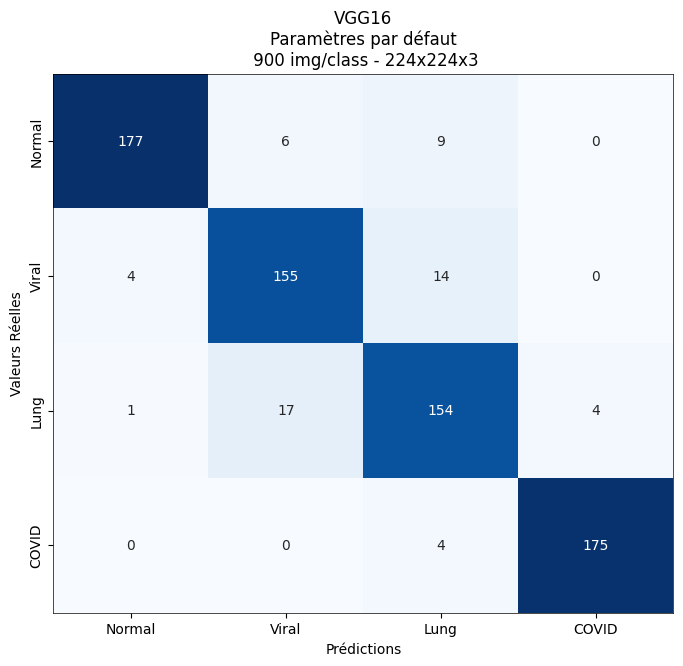

In [7]:
#affichage de la matrice de confusion
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Normal', 'Viral', 'Lung', 'COVID'],
            yticklabels=['Normal', 'Viral', 'Lung', 'COVID'])
plt.title('VGG16\nParamètres par défaut\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# test du modèle VGG19

In [8]:
from tensorflow.keras.applications import VGG19

def build_modified_vgg19(num_classes=4, learning_rate=1e-4):
    # Charger le modèle VGG19 pré-entraîné sans la partie supérieure (top)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Geler toutes les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Ajouter de nouvelles couches
    x = base_model.output
    x = Flatten()(x) 
    x = Dense(256, activation='relu')(x) 
    predictions = Dense(num_classes, activation='softmax')(x) 

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


modelVGG19 = build_modified_vgg19(num_classes=4, learning_rate=1e-4)

In [9]:
#Sauvegarde de l'history et entrainement du modèle
historyVGG19 = modelVGG19.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.6188 - loss: 0.9144 - val_accuracy: 0.8514 - val_loss: 0.4151
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8683 - loss: 0.3791 - val_accuracy: 0.8361 - val_loss: 0.4185
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8886 - loss: 0.2978 - val_accuracy: 0.8667 - val_loss: 0.3591
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9086 - loss: 0.2735 - val_accuracy: 0.8694 - val_loss: 0.3157
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9299 - loss: 0.2201 - val_accuracy: 0.8625 - val_loss: 0.3627
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9400 - loss: 0.1817 - val_accuracy: 0.9083 - val_loss: 0.2528
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9504 - loss: 0.1607 - val_accuracy: 0.9056 - val_loss: 0.2479
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9673 - loss: 0.1214 - val_accuracy: 0.9056 - v

/tmp/ipykernel_1239/4284603125.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(historyVGG19.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
/tmp/ipykernel_1239/4284603125.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(historyVGG19.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')


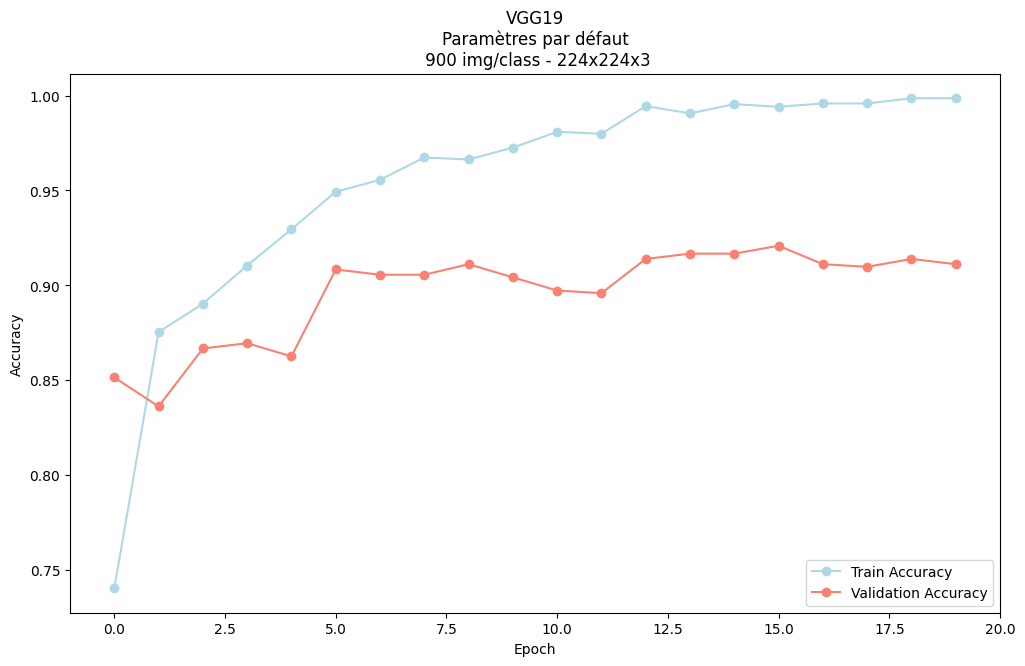

In [10]:
#Affichage de l'accuracy en fonction du temps 
plt.figure(figsize=(12, 7))
plt.plot(historyVGG19.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
plt.plot(historyVGG19.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')
plt.title('VGG19\nParamètres par défaut\n 900 img/class - 224x224x3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(-1,20)
plt.legend(loc='lower right')
plt.show()


In [11]:
# Prédiction sur l'ensemble de test
y_pred = modelVGG19.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
              precision    recall  f1-score   support

       COVID       0.92      0.95      0.93       192
        Lung       0.84      0.91      0.88       173
      Normal       0.91      0.81      0.86       176
       Viral       0.97      0.97      0.97       179

    accuracy                           0.91       720
   macro avg       0.91      0.91      0.91       720
weighted avg       0.91      0.91      0.91       720



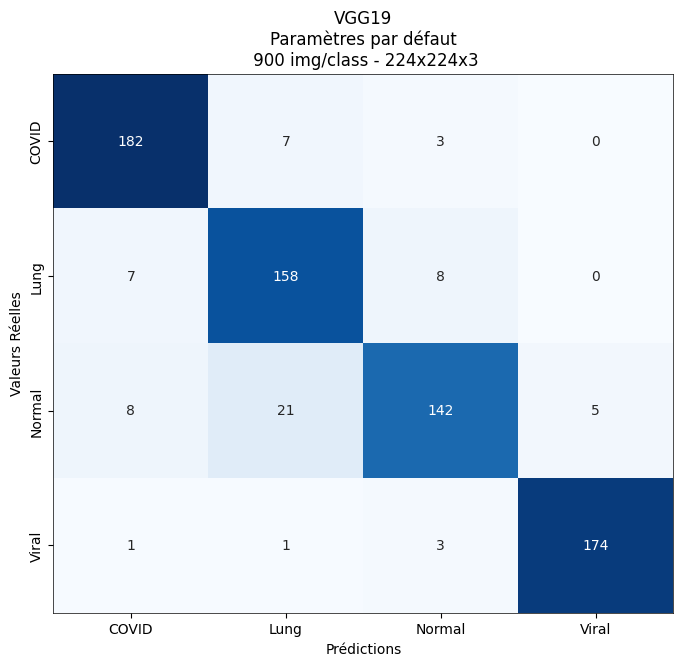

In [12]:
#affichage de la matrice de confusion
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d',cbar=False, cmap='Blues',
            xticklabels=['COVID', 'Lung', 'Normal', 'Viral'],
            yticklabels=['COVID', 'Lung', 'Normal', 'Viral'])
plt.title('VGG19\nParamètres par défaut\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# test du modèle ConvNextTiny

In [13]:
# importation et preprocessing des images
data, target = preproc_img(df_images, df_masks, n_img=900, normalize=False, files_path='PATH_NOMASK', resolution=[224, 224, 3], with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.convnext import ConvNeXtTiny

def build_modified_convnext_tiny(num_classes=4, learning_rate=1e-4):
    # Charger le modèle ConvNextTiny pré-entraîné sans la partie supérieure (top)
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    # Geler toutes les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Ajouter de nouvelles couches
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Utiliser GlobalAveragePooling pour réduire les dimensions
    x = Dense(256, activation='relu')(x)  # Ajouter une couche dense intermédiaire
    predictions = Dense(num_classes, activation='softmax')(x)  # Nouvelle couche de sortie pour 4 catégories

    # Créer le nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiler le modèle avec un taux d'apprentissage spécifique
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Créer une instance du modèle modifié
modelCNT = build_modified_convnext_tiny(num_classes=4, learning_rate=1e-4)

In [16]:
#Sauvegarde de l'history et entrainement du modèle
historyCNT = modelCNT.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20


I0000 00:00:1714056114.104188    5727 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2710', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1714056114.205234    5729 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2710', 268 bytes spill stores, 268 bytes spill loads

I0000 00:00:1714056114.705777    5727 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2881', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1714056115.261464    5735 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2881', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1714056115.512769    5724 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2881', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714056115.651808 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4842 - loss: 1.1623

I0000 00:00:1714056128.254020    5996 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 164 bytes spill stores, 164 bytes spill loads

I0000 00:00:1714056128.587599    6000 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1948', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1714056129.110782    5986 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1948', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1714056129.145392    5996 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 128 bytes spill stores, 128 bytes spill loads



90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.4857 - loss: 1.1602 - val_accuracy: 0.7472 - val_loss: 0.7338
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7747 - loss: 0.6533 - val_accuracy: 0.7806 - val_loss: 0.5969
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7982 - loss: 0.5522 - val_accuracy: 0.8222 - val_loss: 0.5362
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8222 - loss: 0.4961 - val_accuracy: 0.8264 - val_loss: 0.4985
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8557 - loss: 0.4175 - val_accuracy: 0.8292 - val_loss: 0.4725
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8556 - loss: 0.3948 - val_accuracy: 0.8403 - val_loss: 0.4551
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8663 - loss: 0.3883 - val_accuracy: 0.8292 - val_loss: 0.4452
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8784 - loss: 0.3646 - val_accuracy: 0.8375 - val_loss: 

/tmp/ipykernel_1239/4042707949.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(historyCNT.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
/tmp/ipykernel_1239/4042707949.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(historyCNT.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')


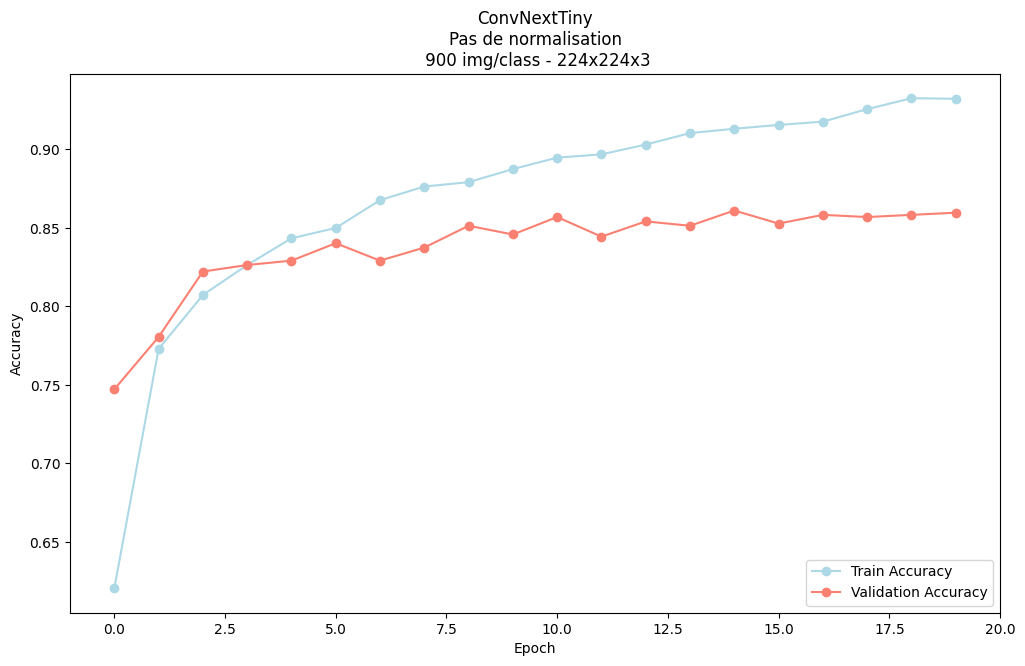

In [17]:
#Affichage de l'accuracy en fonction du temps 
plt.figure(figsize=(12, 7))
plt.plot(historyCNT.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
plt.plot(historyCNT.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')
plt.title('ConvNextTiny\nPas de normalisation\n 900 img/class - 224x224x3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(-1,20)
plt.legend(loc='lower right')
plt.show()


In [18]:
# Prédiction sur l'ensemble de test
y_pred = modelCNT.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step
              precision    recall  f1-score   support

       COVID       0.83      0.84      0.84       192
        Lung       0.85      0.84      0.85       173
      Normal       0.78      0.82      0.80       176
       Viral       0.99      0.94      0.97       179

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



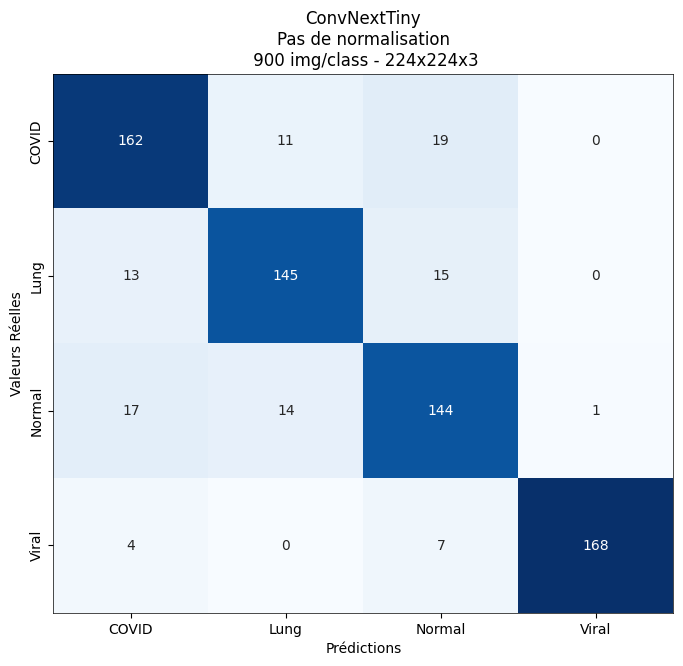

In [19]:
#affichage de la matrice de confusion
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,cmap='Blues',
            xticklabels=['COVID', 'Lung', 'Normal', 'Viral'],
            yticklabels=['COVID', 'Lung', 'Normal', 'Viral'])
plt.title('ConvNextTiny\nPas de normalisation\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# test du modèle ConvNextBase

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.convnext import ConvNeXtBase

def build_modified_convnext_base(num_classes=4, learning_rate=1e-4):
    # Charger le modèle ConvNeXtBase pré-entraîné sans la partie supérieure (top)
    base_model = ConvNeXtBase(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    # Geler toutes les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Ajouter de nouvelles couches
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Utiliser GlobalAveragePooling pour réduire les dimensions
    x = Dense(256, activation='relu')(x)  # Ajouter une couche dense intermédiaire
    predictions = Dense(num_classes, activation='softmax')(x)  # Nouvelle couche de sortie pour 4 catégories

    # Créer le nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiler le modèle avec un taux d'apprentissage spécifique
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Créer une instance du modèle modifié
modelCNB = build_modified_convnext_base(num_classes=4, learning_rate=1e-4)

In [21]:
#Sauvegarde de l'history et entrainement du modèle
historyCNB = modelCNB.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20


I0000 00:00:1714056255.517848    7813 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4888', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1714056255.931071    7805 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4888', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1714056256.312457    7810 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5059', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714056256.480772    7813 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 56 bytes spill stores, 36 bytes spill loads

I0000 00:00:1714056256.656371    7812 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5059', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1714056257.033131    7

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5137 - loss: 1.1794

I0000 00:00:1714056277.225286    8128 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1714056277.411049    8126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1714056277.500719    8122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 56 bytes spill stores, 36 bytes spill loads

I0000 00:00:1714056277.715648    8123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714056278.090461    8122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 124 bytes spill stores, 124 bytes spill loads



90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - accuracy: 0.5153 - loss: 1.1767 - val_accuracy: 0.7583 - val_loss: 0.6739
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.7925 - loss: 0.6005 - val_accuracy: 0.8014 - val_loss: 0.5451
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.8021 - loss: 0.5340 - val_accuracy: 0.8278 - val_loss: 0.4724
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.8434 - loss: 0.4352 - val_accuracy: 0.8403 - val_loss: 0.4381
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.8663 - loss: 0.3749 - val_accuracy: 0.8417 - val_loss: 0.4187
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.8576 - loss: 0.3825 - val_accuracy: 0.8500 - val_loss: 0.3948
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.8870 - loss: 0.3381 - val_accuracy: 0.8542 - val_loss: 0.3831
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.8784 - loss: 0.3272 - val_accuracy: 0.863

/tmp/ipykernel_1239/2395406293.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(historyCNB.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
/tmp/ipykernel_1239/2395406293.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(historyCNB.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')


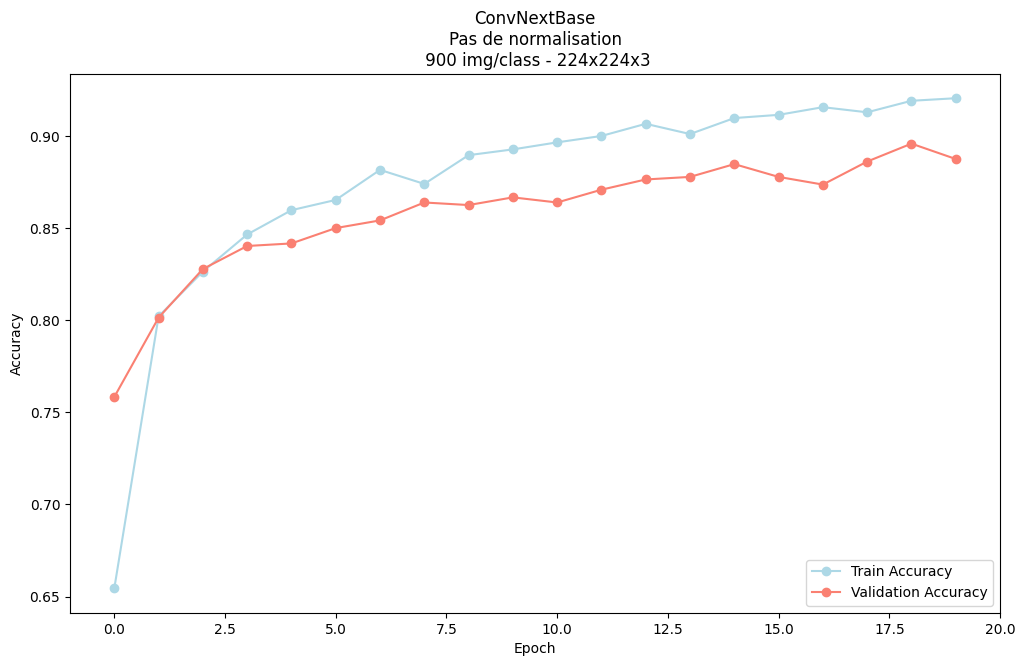

In [22]:
#Affichage de l'accuracy en fonction du temps 
plt.figure(figsize=(12, 7))
plt.plot(historyCNB.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
plt.plot(historyCNB.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')
plt.title('ConvNextBase\nPas de normalisation\n 900 img/class - 224x224x3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(-1,20)
plt.legend(loc='lower right')
plt.show()


In [23]:
# Prédiction sur l'ensemble de test
y_pred = modelCNB.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step
              precision    recall  f1-score   support

       COVID       0.94      0.81      0.87       192
        Lung       0.86      0.91      0.88       173
      Normal       0.80      0.90      0.84       176
       Viral       0.97      0.94      0.95       179

    accuracy                           0.89       720
   macro avg       0.89      0.89      0.89       720
weighted avg       0.89      0.89      0.89       720



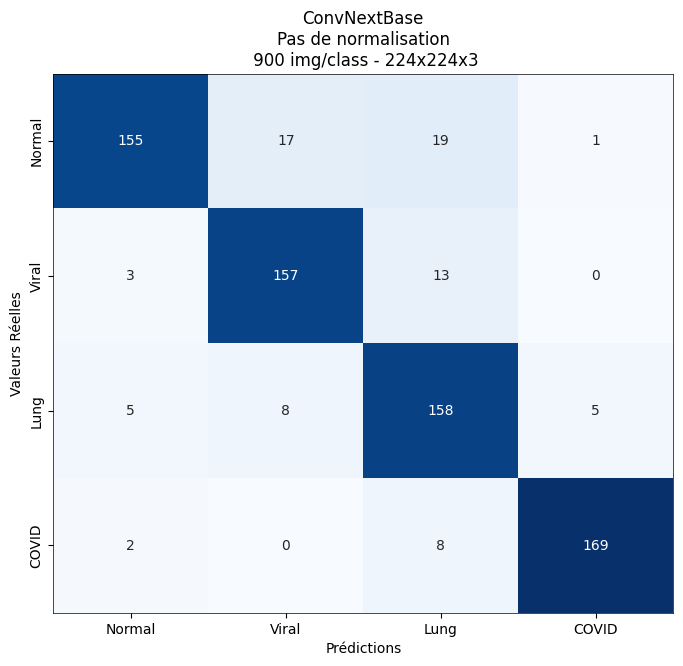

In [24]:
#affichage de la matrice de confusion
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d',cbar=False, cmap='Blues',
            xticklabels=['Normal', 'Viral', 'Lung', 'COVID'],
            yticklabels=['Normal', 'Viral', 'Lung', 'COVID'])
plt.title('ConvNextBase\nPas de normalisation\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()